In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer , Dense , BatchNormalization , Dropout , SimpleRNN , AveragePooling1D , Conv1D , LSTM , GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

In [2]:
name = 1

epochs = 200
patience = epochs // 5 
ticker = 'AAPL'

In [3]:
from yahoofinancials import YahooFinancials
from datetime import datetime

def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pd.DataFrame(columns=["open","close","adjclose"])
    for row in json[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

#chatgpt
def retrieve_stock_returns(ticker, start, end):
    # Fetch historical price data
    json_data = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    
    # Initialize a DataFrame to store returns
    df_returns = pd.DataFrame(columns=["daily_return"])
    
    # Iterate through each row in the JSON response
    for idx, row in enumerate(json_data[ticker]["prices"]):
        # Skip the first row as we can't calculate return for it
        if idx == 0:
            continue
        
        # Calculate the daily return
        current_close = row["close"]
        previous_close = json_data[ticker]["prices"][idx - 1]["close"]
        daily_return = (current_close - previous_close) / previous_close
        
        # Convert the date string to a datetime object
        date = datetime.fromisoformat(row["formatted_date"])
        
        # Add the return to the DataFrame
        df_returns.loc[date] = daily_return
    
    # Set the index name
    df_returns.index.name = "date"
    
    return df_returns

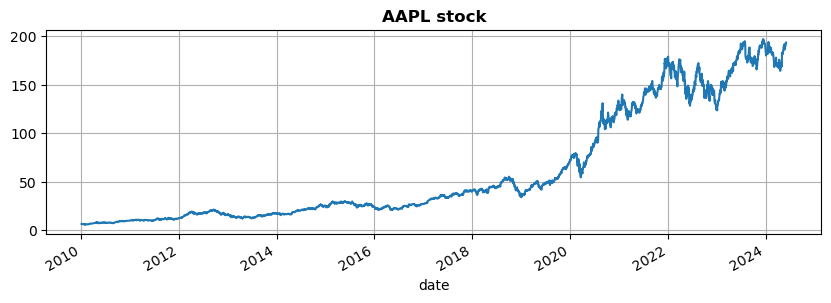

In [4]:
if name == 1:
    stock = retrieve_stock_data(ticker, "2010-01-05", "2024-06-04")

    # work with raw stock value not percentage change
    time_series = stock["adjclose"]#.pct_change() 

    # Make a plot of stock data

    fig = plt.figure()
    fig.set_size_inches(10,3)
    stock["adjclose"].plot()
    plt.title(f'{ticker} stock', weight="bold")
    plt.grid()
    
    #scaling
    time_series = ( time_series - np.mean(time_series) ) / np.max(time_series)
    
if name == 2:
    stock = retrieve_stock_returns(ticker, "2010-01-05", "2024-06-04")
    
    time_series = stock['daily_return']

    fig = plt.figure()
    fig.set_size_inches(10,3)
    time_series.plot()
    plt.title(f'{ticker} stock price returns', weight="bold")
    plt.grid() 

In [5]:
time_series

date
2010-01-05   -0.277765
2010-01-06   -0.278286
2010-01-07   -0.278345
2010-01-08   -0.278131
2010-01-11   -0.278417
                ...   
2024-05-28    0.651014
2024-05-29    0.652532
2024-05-30    0.657593
2024-05-31    0.662451
2024-06-03    0.671460
Name: adjclose, Length: 3627, dtype: float64

In [6]:
# manual dataset preparation because I think it's better

# creating datasets to predict the next (7) day's stock price via the previous month's prices
seq_length = 28
rows = len(time_series.values)-seq_length-7


X = []
Y1 = []

start = 0
# windowing
for start in range(rows):
    x = time_series[start:start+seq_length]
    y1 = time_series[start+seq_length+1]

    X.append(x)
    Y1.append(y1)
   
    
X = np.array(X)
Y1 = np.array(Y1)

X.shape , Y1.shape

/var/folders/yp/01_7yfr14nz5w7y768q78xhh0000gp/T/ipykernel_13553/784953495.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = time_series[start+seq_length+1]


((3592, 28), (3592,))

In [7]:
# train test valid split

np.random.seed(42)
tf.random.set_seed(42)

X_train_full = X[:-1]
y1_train_full = Y1[:-1]

X1_test = time_series[-1-seq_length:-1].values.reshape(1,-1)
y1_test = time_series[-1:].values
X2_test = time_series[-7-seq_length:-7].values.reshape(1,-1)
y2_test = time_series[-7:].values

X_train , X_valid , y1_train , y1_valid = train_test_split(X_train_full , y1_train_full , test_size = 0.2)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [8]:
lstm = keras.models.Sequential([
    keras.layers.Input([None, 1]),
    keras.layers.LSTM(12, return_sequences=True),#, input_shape=[None, 1]),
    keras.layers.LSTM(30 , return_sequences = True),
    keras.layers.LSTM(45 , return_sequences = True),
    keras.layers.LSTM(60 , return_sequences = True),
    keras.layers.LSTM(45 , return_sequences = True),
    keras.layers.LSTM(25 , return_sequences = True),
    keras.layers.LSTM(12, return_sequences=True),
    keras.layers.LSTM(1)
])

lstm.compile(loss="mae" , optimizer="adam")

early_stopping_cb = EarlyStopping(patience=patience,
                                  restore_best_weights=True)

history = lstm.fit(X_train_reshaped, y1_train, epochs=epochs,
                            callbacks = [early_stopping_cb],
                    validation_data=(X_valid_reshaped, y1_valid),
                      verbose = 0)

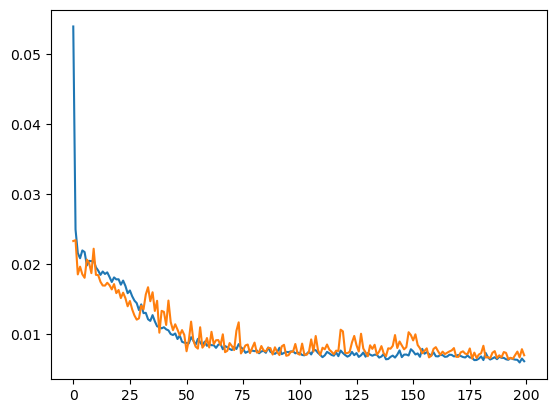

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


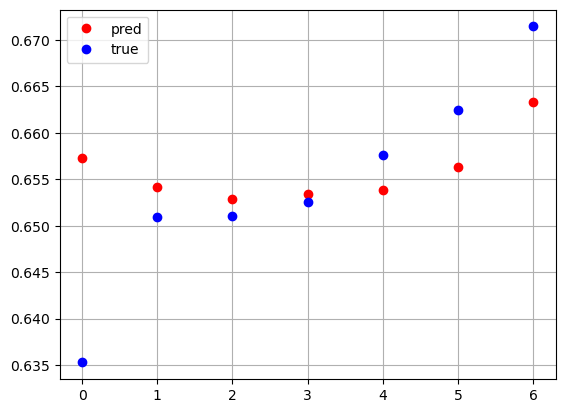

In [10]:
X1_test_reshaped= X1_test.reshape((1 , seq_length , 1))

y1_hat = lstm.predict(X1_test_reshaped)
mae_next_day = mae(y1_hat , y1_test)

y2_hat = []
x = X2_test.copy()

x_reshaped= x.reshape((x.shape[0] , x.shape[1] , 1))

# rolling forecast
for i in range(1, 8):
    y_pred = lstm.predict(x_reshaped)
    y2_hat.append(y_pred[0])

    x = np.concatenate([x[:, 1:], y_pred.reshape(-1, 1)], axis=1)
    x_reshaped= x.reshape((x.shape[0] , x.shape[1] , 1))

y2_hat = np.array(y2_hat)

mae_next_7_days = mae(y2_hat , y2_test)

plt.plot(y2_hat , 'ro' , label = 'pred')
plt.plot(y2_test , 'bo' , label = 'true')
plt.grid()
plt.legend()
plt.show()